In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

## Load and clean electricity by energy source data

In [2]:
# Load dataset
data = pd.read_csv('Data/annual_generation_state.csv', thousands=',')
data.rename(columns={'YEAR': 'year', 'STATE': 'state', 'TYPE OF PRODUCER': 'producer', 'ENERGY SOURCE': 'source', 'GENERATION (Megawatthours)': 'generation'}, inplace=True)

# Change all strings to upper for consistency (state column has 'US-Total' and 'US-TOTAL')
data['state'] = data['state'].str.upper()
data['producer'] = data['producer'].str.upper()
data['source'] = data['source'].str.upper()

# Only keep the information on total electricity generationn for each state
data = data[data['producer'] == 'TOTAL ELECTRIC POWER INDUSTRY']
data.reset_index(drop=True, inplace=True)

# Remove the blank state rows (3 rows for 2003 with 0 generation in coal, natural gas, and petroleum)
data = data[data['state'] != '  ']
print(data.shape)

# Make new dataframe with renewable, nuclear, and total generation 
renewables = ['HYDROELECTRIC CONVENTIONAL', 'WIND', 'WOOD AND WOOD DERIVED FUELS', 'OTHER BIOMASS', 'GEOTHERMAL', 'SOLAR THERMAL AND PHOTOVOLTAIC']
nuclear = ['NUCLEAR']
fossil_fuels = ['COAL', 'NATURAL GAS', 'PETROLEUM', 'OTHER GASES']
other = ['OTHER', 'PUMPED STORAGE']

# Sum renewables
renewable_generation = data[data['source'].isin(renewables)]
renewable_generation = renewable_generation.groupby(['year', 'state'])['generation'].sum().reset_index().rename(columns={'generation': 'generation_renewable'})

# Sum nuclear
nuclear_generation = data[data['source'].isin(nuclear)]
nuclear_generation = nuclear_generation.groupby(['year', 'state'])['generation'].sum().reset_index().rename(columns={'generation': 'generation_nuclear'})

# Sum fossil fuels
fossil_generation = data[data['source'].isin(fossil_fuels)]
fossil_generation = fossil_generation.groupby(['year', 'state'])['generation'].sum().reset_index().rename(columns={'generation': 'generation_fossil'})

# Sum other fuels
other_generation = data[data['source'].isin(other)]
other_generation = other_generation.groupby(['year', 'state'])['generation'].sum().reset_index().rename(columns={'generation': 'generation_other'})

# Sum total
total_generation = data[data['source'] == 'TOTAL'][['year', 'state', 'generation']]
total_generation = total_generation.groupby(['year', 'state'])['generation'].sum().reset_index().rename(columns={'generation': 'generation_tot'})

# Merge all dataframes
merge_1 = pd.merge(renewable_generation, nuclear_generation, on=["year", "state"], how='outer').fillna(0)
merge_2 = pd.merge(merge_1, fossil_generation, on=["year", "state"], how='outer').fillna(0)
merge_3 = pd.merge(merge_2, other_generation, on=["year", "state"], how='outer').fillna(0)
data = pd.merge(merge_3, total_generation, on=["year", "state"], how='outer').fillna(0)

(15914, 5)


## Calculate Interesting statistics for the electricity data
1. Percent of electricity generated by each fuel type
2. YOY change in percentage of electricity generated by each fuel type 

In [3]:
# Calculate the percentage of electricity generated by each fuel type in each state
data['pct_renewable'] = data['generation_renewable'] / data['generation_tot']
data['pct_nuclear'] = data['generation_nuclear'] / data['generation_tot']
data['pct_fossil'] = data['generation_fossil'] / data['generation_tot']
data['pct_other'] = data['generation_other'] / data['generation_tot']


# Calculate the change in the percentage of electricity generated by each fuel type in each state
data['pct_renewable_change'] = data.groupby('state')['pct_renewable'].diff().fillna(0)
data['pct_nuclear_change'] = data.groupby('state')['pct_nuclear'].diff().fillna(0)
data['pct_fossil_change'] = data.groupby('state')['pct_fossil'].diff().fillna(0)
data['pct_other_change'] = data.groupby('state')['pct_other'].diff().fillna(0)

## Visualize the change in pct of electricity generation using renewable sources

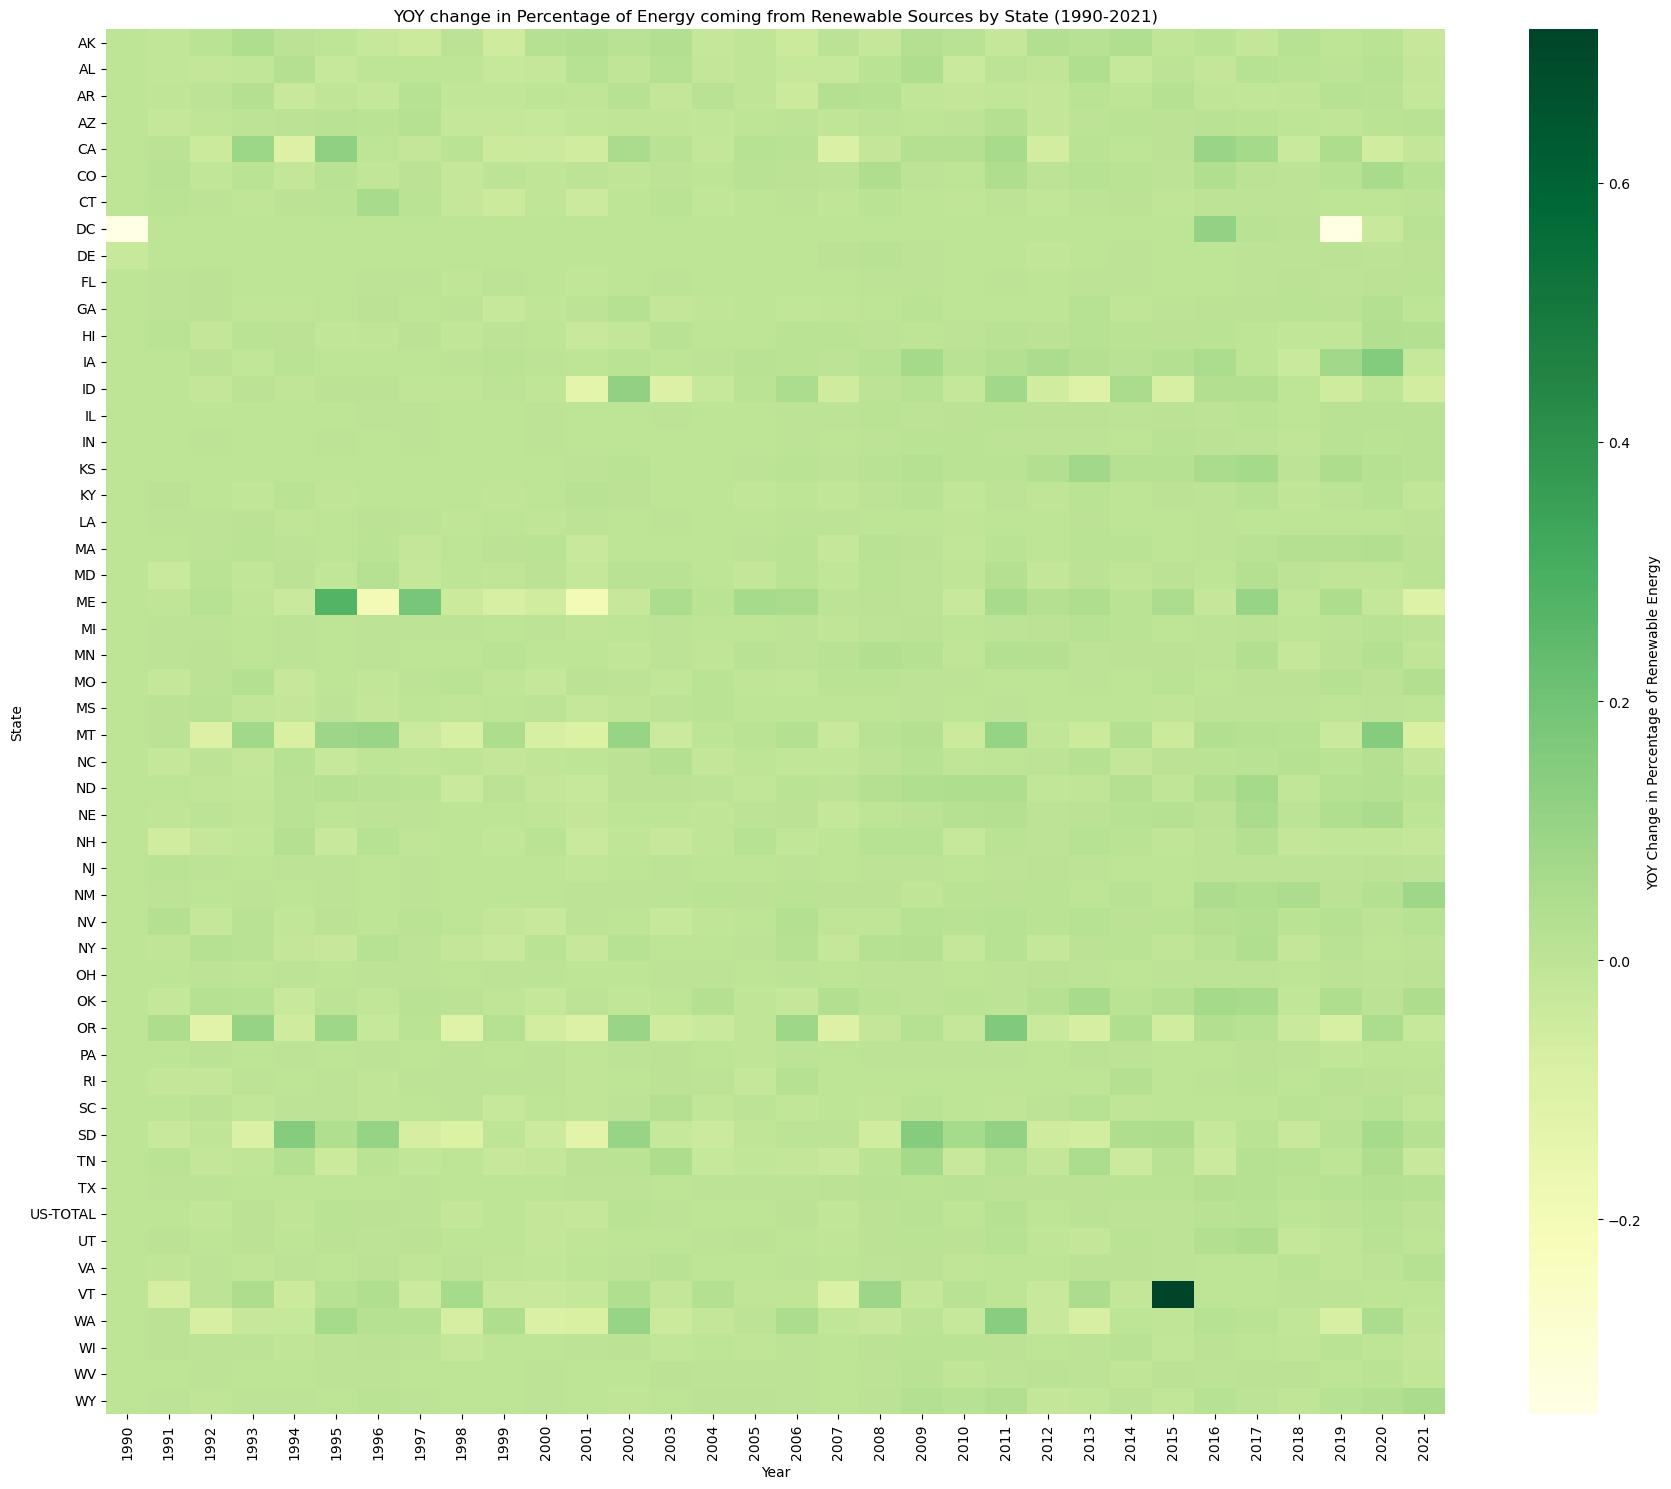

In [4]:
# Pivot the data for heatmap
heatmap_data = data.pivot(index="state", columns="year", values="pct_renewable_change")
    
# Plotting
plt.figure(figsize=(18, 15))
sns.heatmap(heatmap_data, cmap="YlGn", cbar_kws={'label': 'YOY Change in Percentage of Renewable Energy'})
plt.title("YOY change in Percentage of Energy coming from Renewable Sources by State (1990-2021)")
plt.ylabel("State")
plt.xlabel("Year")
plt.tight_layout()
plt.show()